# ドライブ連携

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/')

Mounted at /content/drive


# インストール

In [2]:
!pip install timm==0.4.12 # バージョン指定しないとエラーでる
!pip install japanize-matplotlib 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 376 kB 24.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.1 MB 28.3 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=cfc7f8d484908721d2b48c8722e5347011a9abd0fb28daa604c26b147abed048
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib


# インポート

In [25]:
import pandas as pd
import glob
import numpy as np
import math
import random
import shutil
import stat
import os
from typing import Optional, List

import cv2
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib as mpl
import japanize_matplotlib
import seaborn as sns
sns.set_palette('husl')

import timm
from timm.models.efficientnet import EfficientNet
import torch
import torch.utils.data as data
from torchvision import models, transforms
import torch.nn.functional as F

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold, StratifiedKFold
from scipy.spatial import distance

import warnings
warnings.filterwarnings('ignore')

# EffNetで推論

## 関数

### データセット作成

In [4]:
# 画像パスと良品or不良品カラムのdf作成
def create_df(target):
    
    df = pd.DataFrame()
    
    good_list = glob.glob(BASE_PATH + target + "/good/**.jpg") # jpgを取得
    good_list_png = glob.glob(BASE_PATH + target + "/good/**.png") # pngを取得
    good_list.extend(good_list_png)

    bad_list = glob.glob(BASE_PATH + target + "/bad/**.jpg") # jpgを取得
    bad_list_png = glob.glob(BASE_PATH + target + "/bad/**.png") # pngを取得
    bad_list.extend(bad_list_png)

    df["path"] = good_list + bad_list
    df["quality"] = ""
    df["quality"][:len(good_list)] = "good"
    df["quality"][len(good_list):] = "bad"
    
    return df

In [5]:
# Dataset作成
class Dataset(data.Dataset):
    def __init__(self, 
                 train_list: List[List[str]], resize=(400, 400), phase="train"):
        
        self.file_list = train_list
        self.phase = phase
        self.transform = ImageTransform(resize) # ImageTransformクラスをインスタンス化

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx: int):
        self.img_path = self.file_list[idx]
        img = Image.open(self.img_path).convert("RGB")  # [高さ][幅][色RGB]
        # img = Image.open(self.img_path).convert('L').convert("RGB") # グレースケール→RGBに戻してカラー情報を無くす
        
        # 画像の前処理を実施 
        img = self.transform(img, self.phase) # メソッドを指定してないので、ImageTransformクラスのcallが呼び出される

        return img

In [6]:
# 画像拡張
class ImageTransform():
    def __init__(self, resize):
        
        # RandomResizedCropで比率をランダムに変える場合
        # ratio_min = (resize[1] / resize[0]) * random.uniform(0.1, 0.5)
        # ratio_max = (resize[1] / resize[0]) * random.uniform(1.0, 2.0)
        # print("ratio_min", ratio_min)
        # print("ratio_max", ratio_max)
                    
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.7), # 左右反転
                transforms.RandomVerticalFlip(p=0.7), # 上下反転
                transforms.RandomResizedCrop(resize , scale=(0.08, 1.0), ratio=(0.5, 1.5)),                
                # transforms.RandomResizedCrop(resize , scale=(0.5, 1.0), ratio=(ratio_min, ratio_max)), 
                # transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.25), # hueは-0.5-0.5の範囲、それ以外は0以上
                # transforms.RandomHorizontalFlip(p=0.5), # 左右反転
                # transforms.RandomVerticalFlip(p=0.5), # 上下反転
                # # transforms.Grayscale(num_output_channels=1), # グレースケール変換
                # transforms.RandomEqualize(p=1), # 平坦化
                transforms.ToTensor(),  # テンソルに変換
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # 0-1 → 標準化
            ]),
            'val': transforms.Compose([
                transforms.Resize(resize),  # リサイズ
                # transforms.Grayscale(num_output_channels=1), # グレースケール変換
                transforms.ToTensor(),  # テンソルに変換
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # 0-1 → 標準化
            ])
        }

    def __call__(self, img, phase='train'):
        return self.data_transform[phase](img)

In [7]:
# Dataset,dataloader作成
def create_loader(data_splits, resize, phase):
    dataset = Dataset(data_splits, resize=resize, phase=phase)
    dataloader = data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=True, drop_last=True)
    return dataloader

### 特徴量抽出・距離計算

In [8]:
# effnetの各階層の特徴量の配列を格納（推論する際は使用する層を指定する）
def extract_features(inputs: torch.Tensor, 
                     model: EfficientNet,
                     level):
    features = dict()
    # extract stem features as level 1
    x = model.conv_stem(inputs)
    x = model.bn1(x) 
    x = model.act1(x)  
    features['level_1'] = F.adaptive_avg_pool2d(x, 1) # 畳み込みで1次元の値抽出
    # extract blocks features as level 2~8
    for i, block_layer in enumerate(model.blocks): # 画像サイズ大きいとこのループの途中でメモリ不足になる
        x = block_layer(x)
        features[f'level_{i+2}'] = F.adaptive_avg_pool2d(x, 1)
        # print(f'level_{i+2}', features[f'level_{i+2}'].shape) 
    # extract top features as level
    x = model.conv_head(x)
    x = model.bn2(x)
    x = model.act2(x)
    features['level_9'] = F.adaptive_avg_pool2d(x, 1)
    
    return features['level_{}'.format(str(level))]

In [9]:
# 教師データの特徴量、平均、共分散を求める
def get_mean_cov(loader, level):
    feat = []

    for inputs in loader:
        inputs = inputs.to(device)
        feat_list = extract_features(inputs, model, level) # levelは1~9のint, featuresは上述のextract_features()結果
        feat_list = feat_list.cpu().detach().numpy()
        for i in range(len(feat_list)):
            feat.append(feat_list[i].reshape(-1))

    feat = np.array(feat)

    mean = np.mean(feat, axis=0)
    cov = np.cov(feat.T)

    return feat, mean, cov

In [10]:
# マハラノビス距離算出
def get_score(feat, mean, cov):
    result = []
    cov_i = np.linalg.pinv(cov) # 共分散行列の逆行列を計算
    
    for i in range(len(feat)):
        result.append(distance.mahalanobis(feat[i], mean, cov_i))
           
    return result, cov_i

In [11]:
# 上の3つの関数を使って、教師データ、テストデータのマハラノビス距離を算出
def cal_score():
    # 特徴量抽出  feat：(画像枚数, 344の要素の配列）、mean:featの列ごとの平均、cov:featの共分散行列
    train_good_feat, mean, cov = get_mean_cov(train_good_loader, level) 
    test_good_feat, _, _ = get_mean_cov(test_good_loader, level)
    test_bad_feat, _, _ = get_mean_cov(test_bad_loader, level)

    # マハラノビス距離を計算
    train_good_score, cov_i = get_score(train_good_feat, mean, cov) 
    test_good_score, _ = get_score(test_good_feat, mean, cov)
    test_bad_score, _ = get_score(test_bad_feat, mean, cov)

    # マハラノビス距離を正規化
    def min_max(l):
        l_min = min(l)
        l_max = max(l)
        return [(i - l_min) / (l_max - l_min) for i in l], l_min, l_max

    total_score = train_good_score + test_good_score + test_bad_score    
    total_score, score_min, score_max = min_max(total_score)
    
    train_good_score = total_score[:len(train_good_score)]
    test_good_score = total_score[len(train_good_score):len(train_good_score) + len(test_good_score)]
    test_bad_score = total_score[len(train_good_score) + len(test_good_score):]
        
    # 保存
    save_dir = SAVE_PATH + "np_file/" + save_str 
    os.makedirs(save_dir, exist_ok = True)
    np.save(save_dir + '/mean', mean)
    np.save(save_dir + '/cov', cov)
    np.save(save_dir + '/cov_i', cov_i)
    
    # 表示
    df = pd.DataFrame(np.arange(12).reshape(3, 4),
                  columns=['col_0', 'col_1', 'col_2', 'col_3'],
                  index=['row_0', 'row_1', 'row_2'])
    
    pd.options.display.precision = 3
    pd.options.display.float_format = '{:.3f}'.format
    df_score = pd.DataFrame([[len(train_good_score), len(test_good_score), len(test_bad_score)],
                             [np.mean(train_good_score), np.mean(test_good_score), np.mean(test_bad_score)]],
                            columns=[str_disp[0], str_disp[1], str_disp[2]],
                            index=["データ数", "マハラノビス距離(平均)"])
    display(df_score)
    
    return train_good_score, test_good_score, test_bad_score, mean, cov, cov_i, score_min, score_max

### 評価指標

In [12]:
# auc,confusion_matrix抽出、f1が最大となる閾値を保存
def cal_auc():
    y_true = np.zeros(len(test_good_total)+len(test_bad_total))
    y_true[len(test_good_total):] = 1 #0:正常、1：異常

    # FPR, TPRをthresholdsの数だけ算出
    fpr, tpr, thresholds = metrics.roc_curve(y_true, np.hstack((test_good_total, test_bad_total)))

    # AUC（ROC曲線下の面積）
    auc = metrics.auc(fpr, tpr)
    # print("AUC", auc)
    
    # f1が最大となる閾値での混同行列
    test_total = test_good_total + test_bad_total

    f1_list = []
    for thres in thresholds:
        y_pred = [1 if x > thres else 0 for x in test_total]
        f1 = f1_score(y_true, y_pred)
        f1_list.append(f1)

    f1_max = max(f1_list)
    f1_max_index = f1_list.index(f1_max)

    y_pred_f1_max = [1 if x > thresholds[f1_max_index] else 0 for x in test_total]
    con = confusion_matrix(y_true, y_pred_f1_max)

    df_con = pd.DataFrame(con,
                         columns=["予測：良品", "予測：異常"],
                         index=["実際：良品", "実際：異常"])
    display(df_con)
    
    # 閾値を保存
    df_thres = pd.DataFrame([[thresholds[f1_max_index], score_min, score_max]], 
                            columns=["threshold", "min", "max"])
    df_thres.to_csv(SAVE_PATH + "np_file/" + save_str + "/threshold.csv", index=False)
    
    return auc, fpr, tpr, thresholds, y_true, y_pred_f1_max, df_con

### 画像保存

In [13]:
# 画像削除用（shutil.rmtreeでは読み取り専用のファイルが削除できなかった）
def rmtree(top):
    for root, dirs, files in os.walk(top, topdown=False):
        for name in files:
            filename = os.path.join(root, name)
            os.chmod(filename, stat.S_IWUSR)
            os.remove(filename)
        for name in dirs:
            os.rmdir(os.path.join(root, name))
    os.rmdir(top)  

# 予測結果の正誤別に画像を保存
def save_images():
    df_pred = pd.DataFrame()
    df_pred["true"] = y_true
    df_pred["pred"] = y_pred
    df_pred["path"] = test_good_list + test_bad_list
    df_pred["score"] = test_good_total + test_bad_total

    save_img_path = SAVE_PATH + "result_images/" + save_str
    
    if os.path.exists(save_img_path):
        rmtree(save_img_path)
    os.makedirs(save_img_path, exist_ok = False)
    pred_allocate = ["/good_correct/", "/bad_false/", "/good_false/", "/bad_correct/"]

    for i, j, k in zip(pred_allocate, [0, 1, 0, 1], [0, 0, 1, 1]):
        os.makedirs(save_img_path + i, exist_ok = False)
        df_tmp = df_pred[(df_pred["true"] == j) & (df_pred["pred"] == k)].reset_index(drop=True)

        for tmp_path, score in zip(df_tmp["path"].tolist(), df_tmp["score"].tolist()):
            copy_path = save_img_path + i + tmp_path.split("/")[-3] + "_" + str(round(score, 3)) + "_" + tmp_path.split("/")[-1]
            shutil.copy(tmp_path, copy_path) 
        # print(i, ": ", len(os.listdir(save_img_path + i)))

### 可視化

In [14]:
# 教師データ、テストデータのマハラノビス距離のヒストグラム
def make_hist():
    feature_name = 'マハラノビス距離'

    df_train = pd.DataFrame(train_good_total, columns=[feature_name])
    df_train["kind"] = str_disp[0]
    df_tg = pd.DataFrame(test_good_total, columns=[feature_name])
    df_tg["kind"] = str_disp[1]
    df_tb = pd.DataFrame(test_bad_total, columns=[feature_name])
    df_tb["kind"] = str_disp[2]
    df_hist = pd.concat([df_train, df_tg, df_tb]).reset_index(drop=True)

    # 最大値と最小値の間をn_bin等分した幅でヒストグラムの棒を表示するように設定（各targetのbin幅を統一する）
    n_bin = 30
    x_max = df_hist[feature_name].max()
    x_min = df_hist[feature_name].min()
    bins = np.linspace(x_min, x_max, n_bin)

    for target in str_disp:
        plt.hist(df_hist[df_hist["kind"] == target][feature_name], bins=bins, alpha=0.6, label=target)
    plt.title(feature_name)
    plt.legend()
    plt.show()

In [15]:
# 散布図（ヒストグラムあるので未使用）
# def make_scatter():
#     plot_size = 10
#     alpha = 0.5
#     fig = plt.figure()
#     plt.title("Mahalanobis distance")
#     plt.scatter(list(range(len(train_good_total))), train_good_total, label="train(good)", s=plot_size, alpha=alpha)
#     plt.scatter(list(range(len(test_good_total))), test_good_total, label="test(good)", s=plot_size, alpha=alpha)
#     plt.scatter(list(range(len(test_bad_total))), test_bad_total, label="test(bad)", s=plot_size, alpha=alpha)
#     plt.legend()
#     plt.show()
#     # fig.savefig(SAVE_PATH + "plot_distance/" + TARGET + ".png")

In [16]:
# ROC曲線
def make_roc():
    fig = plt.figure()
    plt.plot(fpr, tpr, label='(AUC = %.3f)'%(auc))

    plt.legend()
    plt.title('ROC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.show()

### その他

In [17]:
# ランダムのseed設定
def set_seed(seed:int=0):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

In [18]:
# # マハラノビス距離がnanになる場合があるので、その際は応急処置として0にする
# def change_nan():
#     # nanの数を調べる
#     nan_total = []
#     for i in [train_good_score, test_good_score, test_bad_score]:
#         nan_list = [1 if math.isnan(x) else 0 for x in i]
#         nan_total.append(nan_list)
#         # print("nanの数：", sum(nan_list))
#     print("nanの数：", sum(sum(nan_total, [])))

#     # nanがあれば0にする
#     train_good_score = [0 if math.isnan(x) else x for x in train_good_score] 
#     test_good_score = [0 if math.isnan(x) else x for x in test_good_score] 
#     test_bad_score = [0 if math.isnan(x) else x for x in test_bad_score] 

#     return train_good_score, test_good_score, test_bad_score

## 実行

### モデル定義

In [19]:
model_name = 'tf_efficientnet_b4_ns' # 'tf_efficientnet_b6_ns'
device="cuda"

model = timm.create_model(model_name, pretrained=True)
model.eval() # 推論モードに切り替え
model.to(device)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b4_ns-d6313a46.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b4_ns-d6313a46.pth


EfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
     

### 変数定義

In [20]:
# シード設定
set_seed(1213)

# パス設定
BASE_PATH = "./dev/20_git/01_anomaly_detection/" 
SAVE_PATH = r'./dev/20_git/01_anomaly_detection/EfficientNet/'

# 推論対象フォルダ
target = "wood" # "screw"

# クロスバリデーション分割数
n_split = 3

# EffNetの特徴量を抽出する階層
level = 7

# 保存時のフォルダ名
save_dir_name = [target, n_split, level]

# データ拡張有無（有り："train"、無し（リサイズのみ）："val"）
train_phase = "val" 
val_phase = "val"

# 表示用
str_disp = ["train(good)", "test(good)", "bad(good)"]

### 推論

========== 1 / 3 =========


,train(good),test(good),bad(good)
データ数,164.000,83.000,20.000
マハラノビス距離(平均),0.000,0.077,0.575


========== 2 / 3 =========


,train(good),test(good),bad(good)
データ数,165.000,82.000,20.000
マハラノビス距離(平均),0.000,0.087,0.563


========== 3 / 3 =========


,train(good),test(good),bad(good)
データ数,165.000,82.000,20.000
マハラノビス距離(平均),0.000,0.100,0.645



■■■■■■■■■■■■■■ テストデータの混同行列 ■■■■■■■■■■■■■■


,予測：良品,予測：異常
実際：良品,247,0
実際：異常,1,59



■■■■■■■■■■■■■■ 全データ平均 ■■■■■■■■■■■■■■


データ数                      マハラノビス距離(平均)                        AUC
     train(good) test(good) bad(good)  train(good) test(good) bad(good)      
全データ         494        247        60        0.000      0.088     0.595 1.000

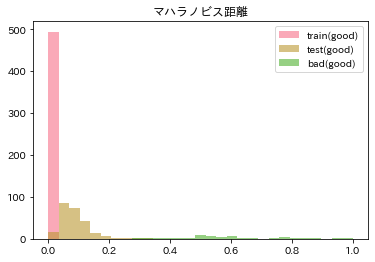

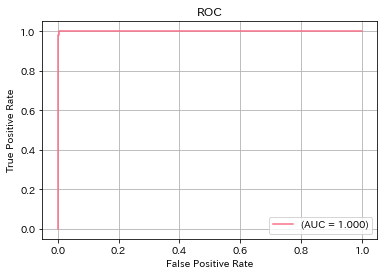

CPU times: user 1min 9s, sys: 3.69 s, total: 1min 13s
Wall time: 1min 51s


In [21]:
%%time
# カラムが画像ファイルのパスと品質（良品or不良品）のデータフレーム作成
df = create_df(target)

# 保存ファイル名に使用
save_str = save_dir_name[0] + "_split-" + str(save_dir_name[1]) + "_level-" + str(save_dir_name[2])

# 全パス（教師データ、テストデータ）格納用
train_good_list, test_good_list, test_bad_list = [], [], []

# 全スコア格納用
train_good_total, test_good_total, test_bad_total = [], [], []

# クロスバリデーション用に分割
skf = StratifiedKFold(n_splits=n_split, shuffle=True, random_state=0)

# 推論実行
for num, index in enumerate(skf.split(df["path"], df["quality"])): 
    print("==========", num+1, "/", n_split, "=========")
    
    # 学習と評価用に分割
    tmp = df.loc[index[0]]
    train_good_splits = tmp["path"][tmp["quality"] == "good"].tolist()
    tmp = df.loc[index[1]]
    test_good_splits = tmp["path"][tmp["quality"] == "good"].tolist()
    test_bad_splits = tmp["path"][tmp["quality"] == "bad"].tolist()
    
    train_good_list.append(train_good_splits)
    test_good_list.append(test_good_splits)
    test_bad_list.append(test_bad_splits)
    
    # リサイズの高さ・幅を計算
    resize = (256, 256)
    
    # データセット作成
    train_good_loader = create_loader(train_good_splits, resize, train_phase)
    test_good_loader = create_loader(test_good_splits, resize, val_phase)
    test_bad_loader = create_loader(test_bad_splits, resize, val_phase)
    
    # マハラノビス距離（スコア）計算
    train_good_score, test_good_score, test_bad_score, mean, cov, cov_i ,score_min, score_max = cal_score()

    # nanがあれば0にする
    # train_good_score, test_good_score, test_bad_score = change_nan()

    # スコア格納
    train_good_total.append(train_good_score)
    test_good_total.append(test_good_score)
    test_bad_total.append(test_bad_score)

    # 保存
    np.save(SAVE_PATH + 'np_file/train_score', train_good_score)
    np.save(SAVE_PATH + 'np_file/cov_i', cov_i)

# 分割毎の画像パスとスコアを平坦化、一つのリストに格納
train_good_list = sum(train_good_list, [])
test_good_list = sum(test_good_list, [])
test_bad_list = sum(test_bad_list, [])

train_good_total = sum(train_good_total, [])
test_good_total = sum(test_good_total, []) 
test_bad_total = sum(test_bad_total, []) 

total_list = [train_good_total, test_good_total, test_bad_total]
    
# 混同行列、AUC
print("")
print("■■■■■■■■■■■■■■ テストデータの混同行列 ■■■■■■■■■■■■■■")
auc, fpr, tpr, thresholds, y_true, y_pred, df_con = cal_auc()

# 評価指標
pd.options.display.precision = 3
df_score = pd.DataFrame([[len(train_good_total), len(test_good_total), len(test_bad_total), np.mean(train_good_total), np.mean(test_good_total), np.mean(test_bad_total), auc]],
                        columns=[
                                 ["データ数", "データ数", "データ数", "マハラノビス距離(平均)", "マハラノビス距離(平均)", "マハラノビス距離(平均)", "AUC"],
                                 [str_disp[0], str_disp[1], str_disp[2], str_disp[0], str_disp[1], str_disp[2], ""]
                        ],
                        index=["全データ"])

print("")
print("■■■■■■■■■■■■■■ 全データ平均 ■■■■■■■■■■■■■■")
display(df_score)

# 画像保存
save_images()
# ヒストグラム
make_hist()
# ROC曲線：
make_roc()

# 異常部位の可視化

## 関数

In [23]:
# マハラノビス距離算出
def get_score_pytorch(feature, mean, cov_i):
    mean = torch.from_numpy(mean).to(device).float()
    cov_i = torch.from_numpy(cov_i).to(device).float()
    result = torch.matmul(feature - mean, cov_i)         # (344,1)x(344,344)？逆にしている？(344,344)x(344,1)=(344,1)？
    result = torch.matmul(result, feature - mean)        # ベクトルとベクトルの積（結果はスカラー）
    # print("Mahalanobis distance", torch.sqrt(result))
    return torch.sqrt(result)

# image_netの平均、分散で標準化？
def make_fig(fig):
    img_mean = [0.485, 0.456, 0.406]
    img_std = [0.229, 0.224, 0.225]
    img = fig.clone().cpu().detach().numpy()
    img = img[0].transpose(1,2,0)
    for i in range(3):
        img[:,:,i] = img[:,:,i]*img_std[i]+img_mean[i]
    return img

## 実行
* sample_noの枚数だけ元の画像を勾配降下法で更新
* figuresは画像のtensor配列が、勾配の繰り返し回数（iteration_num）分格納されている
* figures_listはfiguresが画像枚数分（sample_no）格納されている

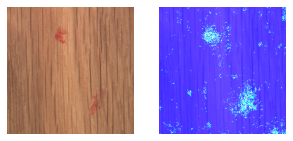

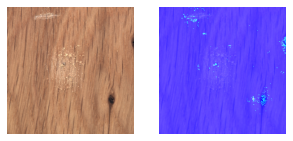

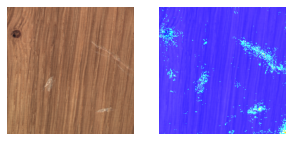

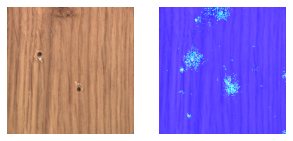

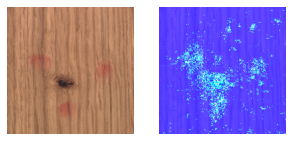

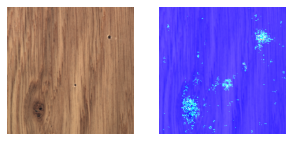

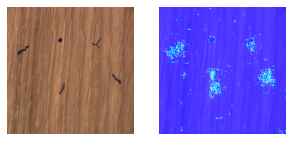

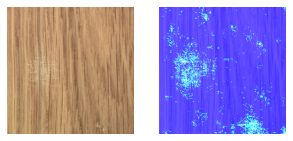

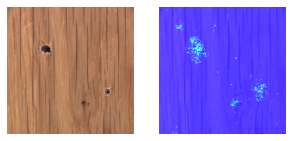

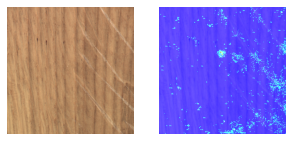

CPU times: user 9.5 s, sys: 107 ms, total: 9.61 s
Wall time: 9.83 s


In [26]:
%%time
# パラメータ
alpha = 0.001       # デフォ：0.0001（学習率？確か値下げると計算時間長くなる）
lamda = 1           # 大きいと色が濃くなり易い？
iteration_num = 10  # 勾配更新の回数

# 表示する画像の枚数
sample_no = 10

# データセット作成
test_bad_dataset = Dataset(test_bad_list, resize=resize, phase="val")
test_bad_loader = data.DataLoader(test_bad_dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=True, drop_last=True)

# 勾配降下法で特徴量を計算・格納
figures_list = []
count = 1
for x_0 in test_bad_loader:
    figures=[]
      
    # initial backward
    x_0 = x_0.to(device).clone().detach().requires_grad_(True)
    feature = extract_features(x_0.to(device), model, level)
    loss = get_score_pytorch(feature.view(-1), mean, cov_i)
    loss.backward(retain_graph=True) # 計算グラフを維持
    x_grad = x_0.grad.data # x_0の勾配を計算
    x_t = x_0 - alpha * x_grad
    
    # backward iteration
    for i in range(iteration_num):
        feature = extract_features(x_t.to(device), model, level)
        score = get_score_pytorch(feature.view(-1), mean, cov_i)
        loss = score + lamda * torch.abs(x_t - x_0).sum()
        loss.backward(retain_graph=True)
        x_grad = x_0.grad.data
        x_t = x_t - alpha * x_grad
        figures.append(make_fig(x_t)) 

    figures_list.append(figures) 
    
    if count==sample_no:
        break
    count+=1

# 可視化
for number, figures in enumerate(figures_list):
    diff = np.abs(figures[0]-figures[-1]) # 1回更新した画像と最後に更新した画像の差分をとる
    diff = np.sum(diff, axis=-1) # 3次元を一次元にする
    diff = (diff-np.min(diff))/(np.max(diff)-np.min(diff)) # 正規化（Min-Max法）
    # plt.imshow(diff, cmap="jet") # 表示

    jetcam = cv2.applyColorMap(np.uint8(255 * diff), cv2.COLORMAP_JET)  # モノクロ画像に疑似的に色をつける
    jetcam = cv2.cvtColor(jetcam, cv2.COLOR_BGR2RGB)  # 色をRGBに変換
    jetcam = (np.float32(jetcam) + figures[0] / 2)   # もとの画像に合成
    
    #画像の読み込み
    im = Image.open(test_bad_list[number])

    #画像をarrayに変換
    im_list = np.asarray(im)
    img_org = Image.fromarray(np.uint8(im_list))
    img_org = np.asarray(img_org.resize(tuple(reversed(resize)))) 

    # 表示
    fig = plt.figure(figsize=(5,5))
    plt.subplot(1,2,1)
    plt.axis("off")
    plt.imshow(img_org)

    plt.subplot(1,2,2)
    plt.imshow(jetcam)
    plt.axis("off")
    plt.show()
    
    # 保存
    fig.savefig(SAVE_PATH + "/plot_figures/" + str(number) + ".png")

# 参照
* 異常検知
    * https://qiita.com/kogepan102/items/122b2862ad5a51180656  
    * https://qiita.com/sUeharaE4/items/023455822376c07cd6ef  
    * https://www.mvtec.com/company/research/datasets/mvtec-ad
    * https://qiita.com/shinmura0/items/5f2c363812f7cdcc8771
    * https://github.com/shinmura0/EfficientNet_AD_Segmentation
* データセット
    * https://www.mvtec.com/company/research/datasets/mvtec-ad/
* フォルダ削除
    * https://www.freenys.net/python/